<a href="https://colab.research.google.com/github/shuphy124/deeplearning_notes/blob/master/section3/3-2-trans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
    
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def get_2d_simple_data(t, v1=.02, v2=.02):
    return np.random.multivariate_normal([np.cos(t), np.sin(t)], np.diagflat([v1, v2]), 100).astype(np.float32)
    
def two_pairplot(x12):
    df_x1 = pd.DataFrame(x12[0], columns=[r"${\bf x}^1$", r"${\bf x}^2$"]); df_x1["class"] = 'y=A'
    df_x2 = pd.DataFrame(x12[1], columns=[r"${\bf x}^1$", r"${\bf x}^2$"]); df_x2["class"] = 'y=B'
    df = pd.concat([df_x1, df_x2],ignore_index=True)
    sns.pairplot(df, hue="class");
    plt.show()


def plot_softmax2(cl=0, N=25):
    X = np.linspace(-1, 1, N)
    Y = np.linspace(-1, 1, N)
    X, Y = np.meshgrid(X, Y)
    XY = np.concatenate([X.reshape(N,N,1), Y.reshape(N,N,1)], axis=2)
    ### tensorflow
    XY_tf = tf.constant(XY) # softmaxはnumpy.arrayではだめっぽい
    Ey = tf.keras.activations.softmax(XY_tf) # これがsoftmax関数の実装
    ###
    contours = plt.contourf(X, Y, Ey[:,:,cl], 20)
    plt.xlabel(r"${\bf z}^0$", fontsize=20); plt.ylabel(r"${\bf z}^1$", fontsize=20)
    plt.title(r"Density of $[\langle {\bf y} \rangle = {\bf \sigma}_{softmax}({\bf z})]^%d$"%cl); plt.colorbar(); plt.show()

def plot_softmax3(cl=0, N=25):
    fig = plt.figure(); ax = fig.gca(projection='3d')
    # Make data.
    X = np.linspace(0, 5, N); Y = np.linspace(0, 5, N)
    X, Y = np.meshgrid(X, Y); Z = 5 - np.abs(Y) - np.abs(X)
    XYZ = np.concatenate([X.reshape(N,N,1), Y.reshape(N,N,1), Z.reshape(N,N,1)], axis=2)
    ### tensorflow
    XYZ_tf = tf.constant(XYZ) # softmaxはnumpy.arrayではだめっぽい
    Ey = tf.keras.activations.softmax(XYZ_tf)
    ###
    # Plot the surface.
    surf = ax.plot_surface(X*(Z>0), Y*(Z>0), Z*(Z>0), facecolors=plt.cm.coolwarm(Ey[:,:,cl]), shade=False)
    # Customize the z axis.
    ax.set_zlim(0, 5); ax.set_ylim([5, 0])
    ax.set_xlabel(r"${\bf z}^0$"); ax.set_ylabel(r"${\bf z}^1$"); ax.set_zlabel(r"${\bf z}^2$")
    ax.set_title(r"Density of $[\langle {\bf y} \rangle = {\bf \sigma}_{softmax}({\bf z})]^%d$"%cl)
    # Add a color bar which maps values to colors.
    sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm); sm.set_array(Ey[:,:,cl])
    fig.colorbar(sm, pad=.2); plt.show()

## 3-2. 神经网络和误差函数
在解释了构成神经网络的基本元素之后，我们将导入深度神经网络。

### 特征量

在给定输入向量 $ {\ bf x} $ 的情况下，我们构造某个变量 $ y $相关的条件概率 $ q_ \ theta (y | {\ bf x}) $。让我们来看看具体例子。 例如，假设有以下二维数据和label $ \ {({\ bf x} _n, y_n) \} $ 的相关数据：

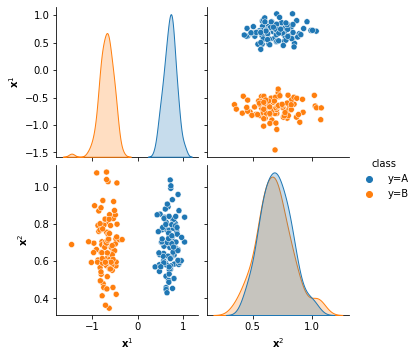

In [11]:
x_A = get_2d_simple_data(t=np.pi/4); x_B = get_2d_simple_data(t=np.pi/4+np.pi/2)
two_pairplot([x_A, x_B])

#### 线性变换
从${\bf x}$的第一个坐标${\bf x}^1$来看这个二维数据，A类和B类是分开的，但是从第二个坐标${\bf x}^2 $的数据，看起来两者之间没有区别。 例如，在这种情况下，我们考虑做适当的线性变换 $ l $后$ {\ bf x} $

$$
{\bf z} = l({\bf x}) = W {\bf x} + {\bf b}，
$$

您可以看到统计数据在两个坐标上都有区别。 线性变换可以在深度学习库中轻松实现。

In [13]:
l = tf.keras.layers.Dense(2, input_shape=(2,)) # 这个是线性变换
z_A = l(x_A); z_B = l(x_B)
two_pairplot([z_A, z_B])

ValueError: ignored

#### 一般特征量
更一般的，非线性变换

$$
{\bf z} = f({\bf x})
$$
使分类等task更容易处理，提取出数据背后的某些特征时，这个被称为**特征量(feature)**。在下文中，我们将神经网络中的特征量的设计，解释为一些随机模型的**期望值**的分层。

### 二进制单位

二元分类是将输入$x$分类为二元标签的问题。 这里，按照惯例，分为1 bit$\{0, 1\}$。 另外，为了简化，我们使用一个分量的实数。

$$
y \in \{0, 1\},
\quad
x \in \mathbb{R}
$$
让我们用统计力学的思想来构造这种情况下的条件概率$q_\theta(y|x)$。
统计力学告诉我们，如果一个自由度系统： $ y $ 和能量 $ E (y) $ 的系统在温度 $ T $ 的环境下进入稳定状态，实现 $ y $ 的概率是

$$
q_E(y)=\frac{e^{- \frac{E(y)}{k_B T}}}{Z}。
$$
然后可以考虑能量。

首先，考虑从外部施加力 $ z $ 的情况。 如果此时$y$是一个实数，那么很自然地认为这将给出一个变化，并作为$z y $的功。 现在$y$是二进制的，但是如果你把它看成一个自旋变量，把$z$看成一个外部磁场也是一样的。 因为倾注的功变成了能量


$$
E(y) = -z y。
$$
这里，所考虑的**力**$z$，正好对应着考虑的**特征量**。通过最简单的线性变换的特征量

$$
z = w x + b，
$$
设为$F(x)$。

这里，如果适当调整$w和b$的尺度，$k_B T$可以被这些值吸收。

$$
q_E(y)=
q_{w, b} (y|x)=
\frac{e^{(w x + b)y}}{Z}。
$$

$Z$是一个 $ y = 0,1 $相关的加法是 1的函数
$$
Z=
\sum_{y=0, 1}
e^{(w x + b)y}=
1 + e^{wx +b}。
$$
>$Z$是统计力学里被称为配分函数的量。

所以得到

$$
q_{w, b} (y|x)=
\frac{e^{(w x + b)y}}{1 + e^{wx +b}}。
$$
这是一个非常简单的随机模型。 $ y = 0,1 $ 的概率分别可以写作

$$
\left. \begin{array}{ll}
&q_{w, b} (y=1|x)=
\frac{e^{w x + b}}{1 + e^{wx +b}}=
\frac{1}{e^{-(w x + b)} + 1}
:=
\sigma(wx + b)
\\
&q_{w, b} (y=0|x)=
1- q_{w, b} (y=1|x)=
1 - \sigma(wx + b)
\end{array} \right.
$$
函数 $ \ sigma $ 有一个名称，称为（逻辑）sigmoid 函数。